In [1]:
# Import libraries
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar')
datafile.extractall()
datafile.close()

/var/folders/ly/x8psxl8d75q0jcffk6_fm8zm0000gn/T/ipykernel_11379/1423455359.py:3: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  datafile.extractall()


In [3]:
import os

train_images_path = "Task01_BrainTumour_2D/training_images"
train_labels_path = "Task01_BrainTumour_2D/training_labels"

# Get file names for images
train_images_files = [f for f in os.listdir(train_images_path) if os.path.isfile(os.path.join(train_images_path, f))]
train_labels_files = [f for f in os.listdir(train_labels_path) if os.path.isfile(os.path.join(train_labels_path, f))]

/var/folders/ly/x8psxl8d75q0jcffk6_fm8zm0000gn/T/ipykernel_11379/1902195132.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(train_images_path + "/" + train_images_files[randints[i]])
/var/folders/ly/x8psxl8d75q0jcffk6_fm8zm0000gn/T/ipykernel_11379/1902195132.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(train_labels_path + "/" + train_images_files[randints[i]])


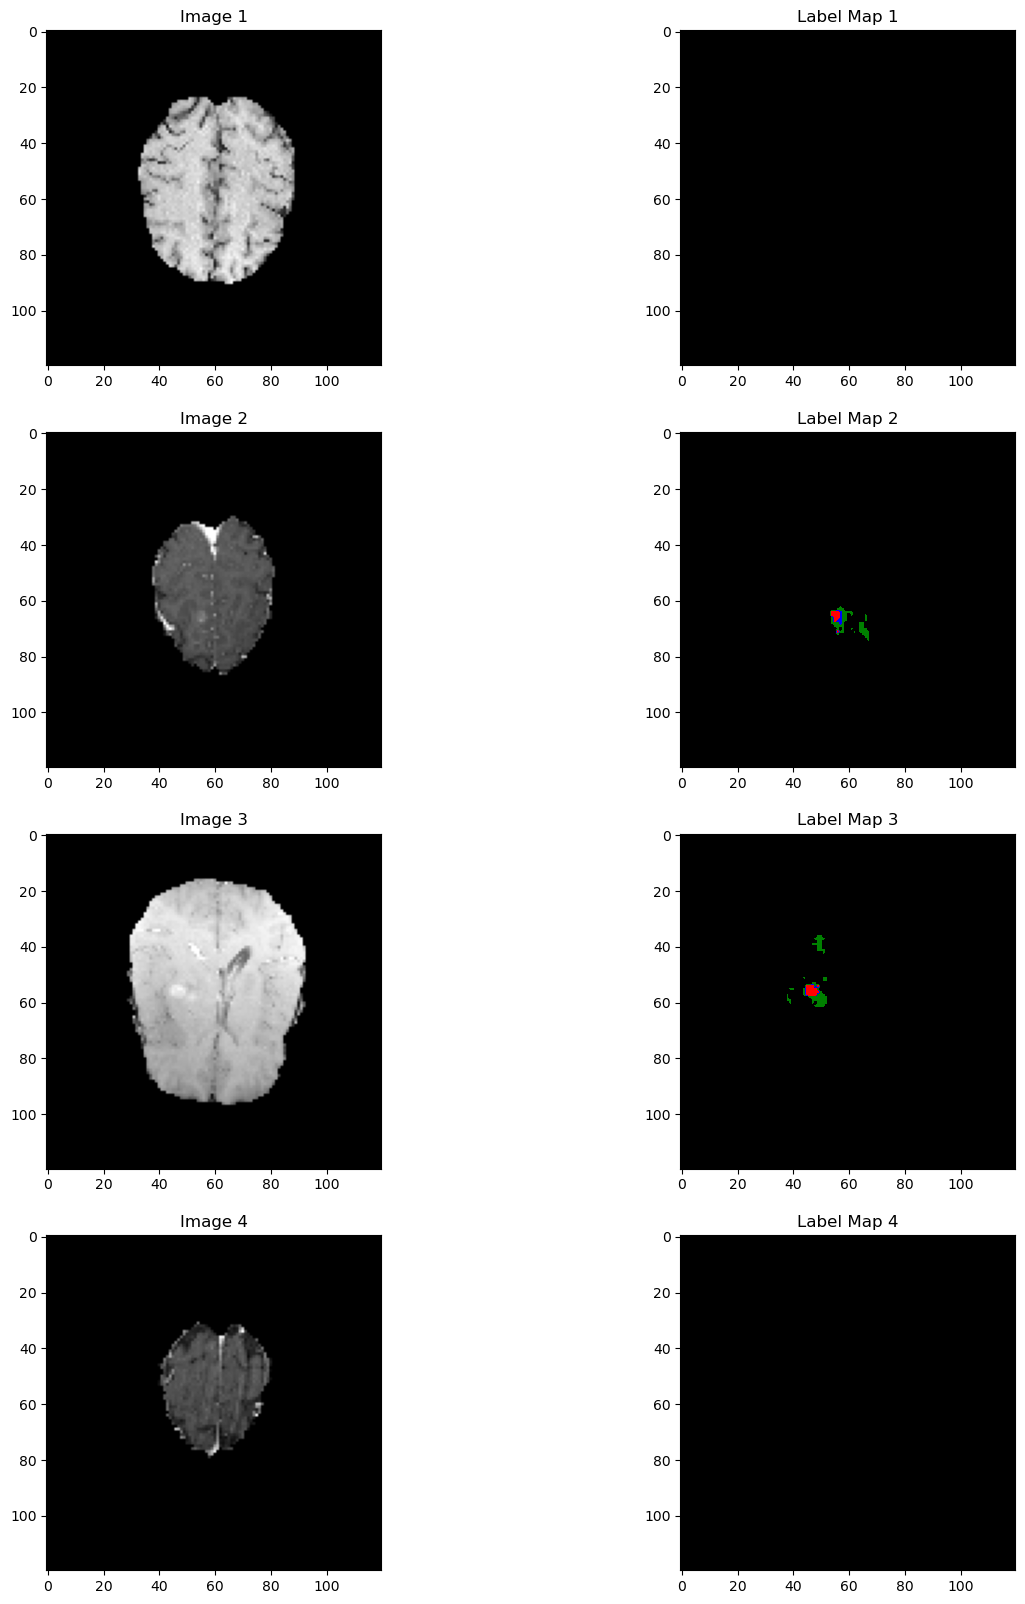

In [4]:
#Visualise the images and their label maps
fig = plt.figure(figsize=(15, 20))
rows = 4
columns = 2

cmap_img = 'gray'
cmap_label = colors.ListedColormap(['black', 'green', 'blue', 'red'])

randints = [random.randint(0, len(train_images_files)) for i in range(4)]
for i in range(len(randints)):
  
    #Image
    fig.add_subplot(rows, columns, 2*(i+1) - 1)
    image = imageio.imread(train_images_path + "/" + train_images_files[randints[i]])
    plt.imshow(image, cmap=cmap_img)
    plt.title("Image " + str(i + 1))

    #Label Map
    fig.add_subplot(rows, columns, 2*(i+1))
    image = imageio.imread(train_labels_path + "/" + train_images_files[randints[i]])
    plt.imshow(image, cmap=cmap_label)
    plt.title("Label Map " + str(i + 1))

In [5]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        randidx = [random.randint(0, len(self)-1) for i in range(batch_size)]
        for i in range(batch_size):
            tup = self[randidx[i]]
            images.append(tup[0])
            labels.append(tup[1])

        images, labels = np.array(images)[:, np.newaxis, :, :], np.array(labels)
        return images, labels

In [6]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()

        )
        
        # Decoder path
        # n = 128
        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(n, int(n/2), kernel_size = 2, stride=2)  
        )

        #conv3_skip gets concatenated here
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(n, int(n/2), kernel_size=3, padding=1),
            nn.BatchNorm2d(n//2),
            nn.ReLU()
        )


        n //= 2 #64
        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(n, int(n/2), kernel_size = 2, stride=2)  
        )

        #conv2_skip gets concatenated here
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(n, int(n/2), kernel_size=3, padding=1),
            nn.BatchNorm2d(n//2),
            nn.ReLU()
        )


        n //= 2 #32
        self.upconv3 = nn.Sequential(
            nn.ConvTranspose2d(n, int(n/2), kernel_size = 2, stride=2)  
        )

        #conv1_skip gets concatenated here
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(n, int(n/2), kernel_size=3, padding=1),
            nn.BatchNorm2d(n//2),
            nn.ReLU()
        )

        n //= 2 #16
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(n, output_channel, kernel_size=1),
            # nn.BatchNorm2d(n//2)
        )



    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        
        x = self.upconv1(x)
        x = torch.concat((x, conv3_skip), 1)
        x = self.dec_conv1(x)

        x = self.upconv2(x)
        x = torch.concat((x, conv2_skip), 1)
        x = self.dec_conv2(x)

        x = self.upconv3(x)
        x = torch.concat((x, conv1_skip), 1)
        x = self.dec_conv3(x)

        x = self.dec_conv4(x)


        return x

In [7]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
num_iter = 2500
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)


    # Perform optimisation and print out the training loss
    optimizer.zero_grad()
    loss = criterion(logits, labels)

    # Backward pass (compute the gradients)
    loss.backward()

    # update parameters
    optimizer.step() 
    
    # Evaluate
    if it % 100 == 0:
        model.eval()
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            images, labels = test_set.get_random_batch(eval_batch_size)
            images, labels = torch.from_numpy(images), torch.from_numpy(labels)
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            logits = model(images)

            loss = criterion(logits, labels)

            print("Iter:", it)
            print("Test Loss:", loss)

    # Save the model
    if it % 500 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cpu


/var/folders/ly/x8psxl8d75q0jcffk6_fm8zm0000gn/T/ipykernel_11379/264090107.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(image_path, image_name))
/var/folders/ly/x8psxl8d75q0jcffk6_fm8zm0000gn/T/ipykernel_11379/264090107.py:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(label_name)


Iter: 100
Test Loss: tensor(0.4030)
Iter: 200
Test Loss: tensor(0.2000)
Iter: 300
Test Loss: tensor(0.1361)
Iter: 400
Test Loss: tensor(0.0770)
Iter: 500
Test Loss: tensor(0.0755)
Iter: 600
Test Loss: tensor(0.0611)
Iter: 700
Test Loss: tensor(0.0621)
Iter: 800
Test Loss: tensor(0.0619)
Iter: 900
Test Loss: tensor(0.0687)
Iter: 1000
Test Loss: tensor(0.0639)
Iter: 1100
Test Loss: tensor(0.0459)
Iter: 1200
Test Loss: tensor(0.0525)
Iter: 1300
Test Loss: tensor(0.0464)
Iter: 1400
Test Loss: tensor(0.0505)
Iter: 1500
Test Loss: tensor(0.0369)
Iter: 1600
Test Loss: tensor(0.0398)
Iter: 1700
Test Loss: tensor(0.0414)
Iter: 1800
Test Loss: tensor(0.0373)
Iter: 1900
Test Loss: tensor(0.0537)
Iter: 2000
Test Loss: tensor(0.0439)
Iter: 2100
Test Loss: tensor(0.0429)
Iter: 2200
Test Loss: tensor(0.0289)
Iter: 2300
Test Loss: tensor(0.0613)
Iter: 2400
Test Loss: tensor(0.0770)
Iter: 2500
Test Loss: tensor(0.0542)
Training took 3882.043s in total.


/var/folders/ly/x8psxl8d75q0jcffk6_fm8zm0000gn/T/ipykernel_11379/3365863150.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('saved_mode

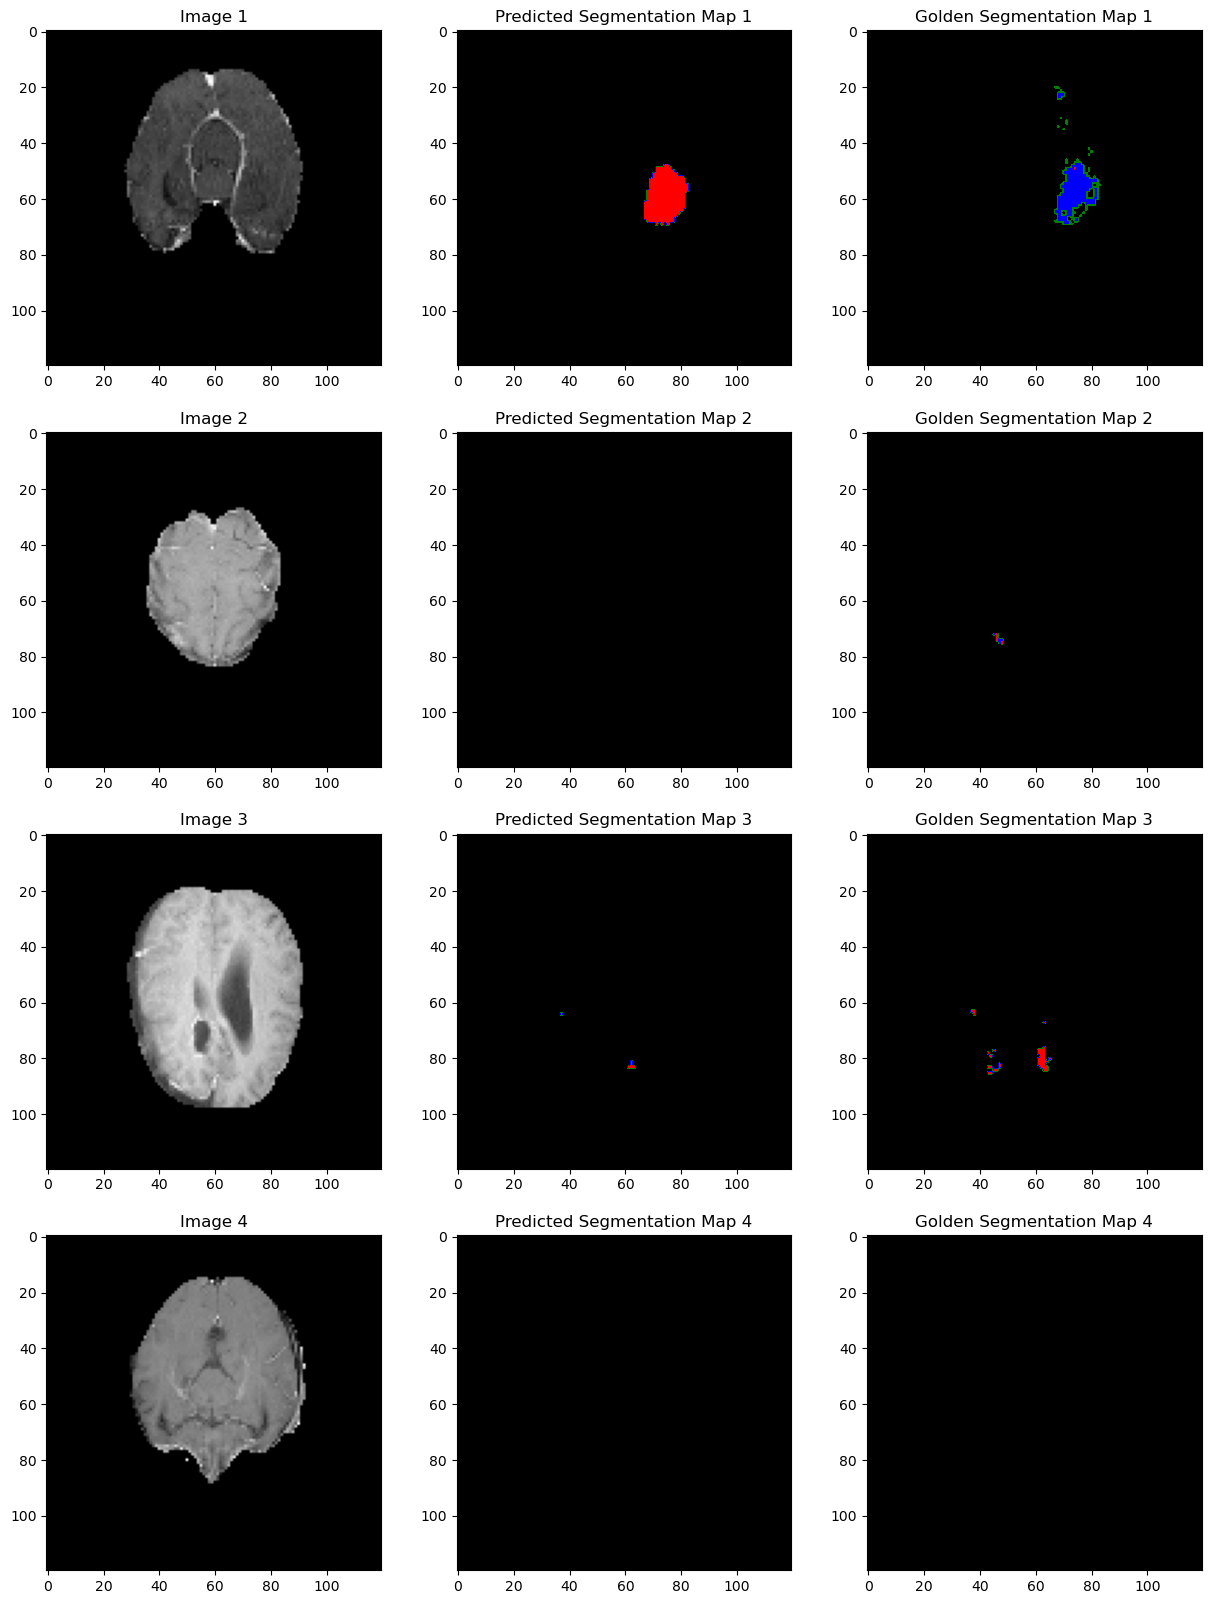

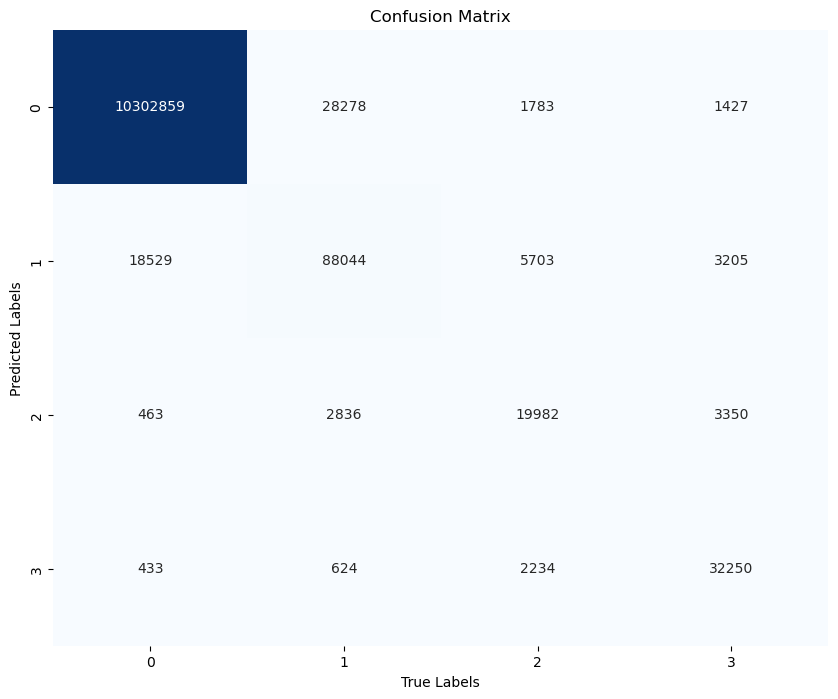

Accuracy: 0.9934489155251142
Class-wise Precision: [0.99811815 0.73503531 0.67274931 0.80160072]
Macro Precision: 0.8018758722145558
Class-wise Recall: [0.99695307 0.76241113 0.75032856 0.90740272]
Macro Recall: 0.8542738720242866
Class-wise F1 Score: [0.99753527 0.74847299 0.70942432 0.85122669]
Macro F1 Score: 0.8266648156989608
Confusion Matrix:
 [[10302859    28278     1783     1427]
 [   18529    88044     5703     3205]
 [     463     2836    19982     3350]
 [     433      624     2234    32250]]


In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

def confmat(preds, true, n):
    """
    Calculate and plot the confusion matrix.
    
    Args:
    preds (list): List of predicted segmentation maps.
    true (list): List of ground truth segmentation maps.
    n (int): Number of classes.
    
    Returns:
    conf_mat (numpy.ndarray): Computed confusion matrix.
    """
    conf_mat = np.zeros((n, n), dtype=int)
    for im in range(len(preds)): 
        for i in range(len(preds[0])):
            for j in range(len(preds[0])):
                pred = preds[im][i][j]
                golden = true[im][i][j]
                conf_mat[pred][golden] += 1

    # Plot the confusion matrix using seaborn's heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=range(n), yticklabels=range(n))
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return conf_mat

def accuracy(confusion_mtx):
    """Calculate accuracy from confusion matrix."""
    return np.sum(np.diagonal(confusion_mtx)) / np.sum(confusion_mtx)

def precision(confusion_mtx):
    """Calculate class-wise and macro precision from confusion matrix."""
    p = np.diagonal(confusion_mtx) / np.sum(confusion_mtx, axis=0)
    macro_p = np.mean(p)
    return (p, macro_p)

def recall(confusion_mtx):
    """Calculate class-wise and macro recall from confusion matrix."""
    r = np.diagonal(confusion_mtx) / np.sum(confusion_mtx, axis=1)
    macro_r = np.mean(r)
    return (r, macro_r)

def f1_score(confusion_mtx):
    """Calculate class-wise and macro F1-score from confusion matrix."""
    precisions, macro_p = precision(confusion_mtx)
    recalls, macro_r = recall(confusion_mtx)
    f = 2 * precisions * recalls / (precisions + recalls)
    macro_f = np.mean(f)
    return (f, macro_f)

# Assuming 'model' is loaded and 'test_set' is defined as per your original code
model.load_state_dict(torch.load('saved_models/model_2500.pt'))
model.eval()

test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

images, labels = train_set.get_random_batch(len(test_set))
images_t, labels_t = torch.from_numpy(images), torch.from_numpy(labels)
images_t, labels_t = images_t.to(device, dtype=torch.float32), labels_t.to(device, dtype=torch.long)



#Visualise the images and their label maps
fig = plt.figure(figsize=(15, 20))
rows = 4
columns = 3

cmap_img = 'gray'
cmap_label = colors.ListedColormap(['black', 'green', 'blue', 'red'])
preds = []
true = []

for i in range(len(images)):
    image = images[i]
    image = torch.from_numpy(image)
    image = image.to(device, dtype=torch.float32)

    prediction = model(image.unsqueeze(0))

    label = torch.from_numpy(labels[i])
    label = label.to(device, dtype=torch.long)
    if (i < 4):
        #Image
        fig.add_subplot(rows, columns, 3*(i+1) - 2)

        plt.imshow(image.cpu().squeeze(), cmap=cmap_img)
        plt.title("Image " + str(i + 1))

        #Predicted Label Map
        fig.add_subplot(rows, columns, 3*(i+1) - 1)

        plt.imshow(np.argmax(prediction.cpu().detach().numpy().squeeze(), axis = 0), cmap=cmap_label)
        plt.title("Predicted Segmentation Map " + str(i + 1))

        #True Label Map
        fig.add_subplot(rows, columns, 3*(i+1))

        plt.imshow(label.cpu().detach().numpy(), cmap=cmap_label)
        plt.title("Golden Segmentation Map " + str(i + 1))
        

    preds.append(np.argmax(prediction.cpu().detach().numpy().squeeze(), axis = 0))
    true.append(label.cpu().detach().numpy())


conf_mat = confmat(preds, true, 4)
print("Accuracy:", accuracy(conf_mat))
print("Class-wise Precision:", precision(conf_mat)[0])
print("Macro Precision:", precision(conf_mat)[1])
print("Class-wise Recall:", recall(conf_mat)[0])
print("Macro Recall:", recall(conf_mat)[1])
print("Class-wise F1 Score:", f1_score(conf_mat)[0])
print("Macro F1 Score:", f1_score(conf_mat)[1])
print("Confusion Matrix:\n", conf_mat)